## Backtest a Single Model 

The way to gauge the performance of a time-series model is through re-training models with different historic periods and check their forecast within certain steps. This is similar to a time-based style cross-validation. More often, we called it `backtest` in time-series modeling.

The purpose of this notebook is to illustrate how to do 'backtest' on a single model using `TimeSeiresSplitter` and `Backtest`. 

`TimeSeiresSplitter` here is used to make the schem for time-based train-test splits with the data given as well as other required parameters.

`Backtest` is the engine performs fitting and scoring based on a `TimeSeiresSplitter` object.

To have the greatest flexibility, this engine is designed to work for any model objects which have a `fit` method and a `predict` method, by writing some call back functions. The default settings work for **Orbit** model object automatically. Currently, there are two schemes supported for the back-testing engine: expanding window and rolling window.

* expanding window: for each back-testing model training, the train start date is fixed, while the train end date is extended forward.
* rolling window: for each back-testing model training, the training window length is fixed but the window is moving forward.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from orbit.lgt import LGT
from orbit.dlt import DLT
from orbit.backtest.backtest import TimeSeriesSplitter, Backtest
from orbit.utils.metrics import mape, smape, wmape

## Load data

In [2]:
data_path = '../examples/data/iclaims.example.csv'
raw_data = pd.read_csv(data_path, parse_dates=['week'])
data = raw_data.copy()
print(data.shape)
data.head(5)

(443, 5)


,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


## Create a TimeSeriesSplitter

###  Expanding window

In [3]:
min_train_len = 380
forecast_len = 20
incremental_len = 20

In [4]:
ex_splitter = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, window_type='expanding', date_col='week')

In [5]:
print(ex_splitter)


------------ Fold: (1 / 3)------------
Train start index: 0 Train end index: 379
Test start index: 380 Test end index: 399
Train start date: 2010-01-03 00:00:00 Train end date: 2017-04-09 00:00:00
Test start date: 2017-04-16 00:00:00 Test end date: 2017-08-27 00:00:00

------------ Fold: (2 / 3)------------
Train start index: 0 Train end index: 399
Test start index: 400 Test end index: 419
Train start date: 2010-01-03 00:00:00 Train end date: 2017-08-27 00:00:00
Test start date: 2017-09-03 00:00:00 Test end date: 2018-01-14 00:00:00

------------ Fold: (3 / 3)------------
Train start index: 0 Train end index: 419
Test start index: 420 Test end index: 439
Train start date: 2010-01-03 00:00:00 Train end date: 2018-01-14 00:00:00
Test start date: 2018-01-21 00:00:00 Test end date: 2018-06-03 00:00:00



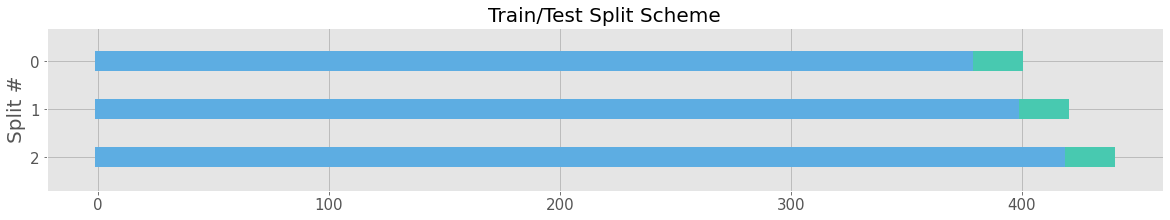

In [6]:
ex_splitter.plot()

### Rolling window

In [7]:
roll_splitter = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, window_type='rolling', date_col='week')

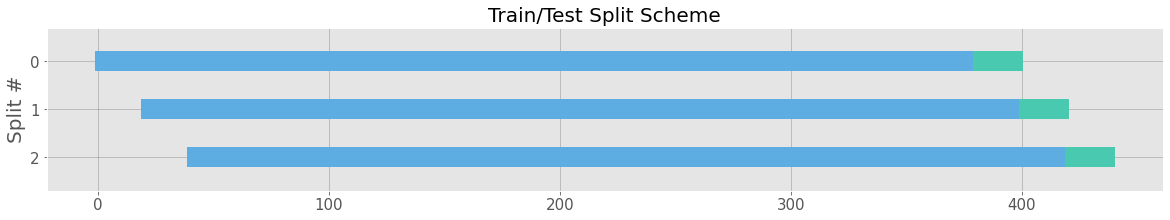

In [8]:
roll_splitter.plot()

### Specifying number of splits

User can also define number of splits using `n_splits` instead of specifying minimum training length.  That way, minimum training length will be automatically calculated.

In [9]:
ex_splitter2 = TimeSeriesSplitter(data, min_train_len, incremental_len, forecast_len, n_splits=5, window_type='expanding', date_col='week')

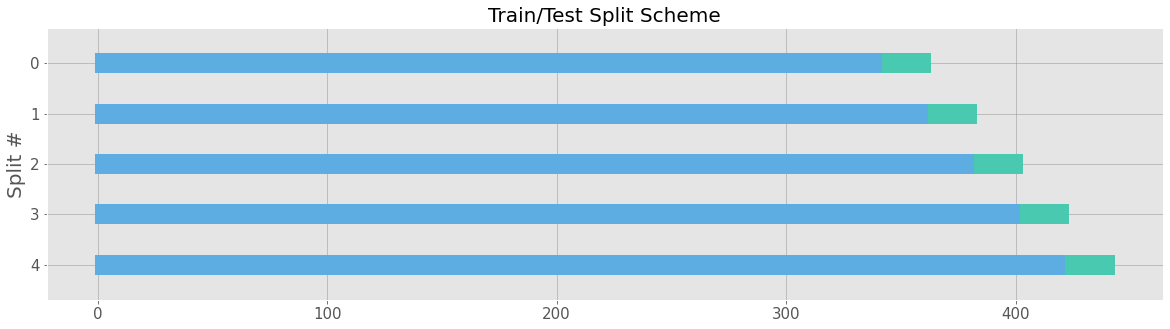

In [10]:
ex_splitter2.plot()

## Backtest

Now, we will use one of the scheme to backtest an `orbit` model.

In [11]:
bt = Backtest(splitter=ex_splitter2)

Instantiate a model that we want to backtest

In [12]:
mod = LGT(
    date_col = 'week',
    response_col = 'claims',
    regressor_col = ['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality = 52,
    seed = 8888,
    predict_method = 'map',
    auto_scale=True,
    is_multiplicative=True
)

Use `fit_score()` to fit the model and computed the desired metrics

In [13]:
bt.fit_score(model=mod, response_col = 'claims', predicted_col='prediction', metrics={"smape": smape, "mape": mape})

Retrieve raw predictions for every split

In [14]:
bt.get_predictions().head(5)

,steps,week,claims,trend.unemploy,trend.filling,trend.job,prediction,split_key
0,1,2016-07-31,219202,1.183973,0.966504,1.013595,217299.775514,0
1,2,2016-08-07,231542,1.125745,0.909651,0.966451,229474.014942,0
2,3,2016-08-14,219570,1.145154,0.966504,0.942879,221133.954975,0
3,4,2016-08-21,217011,1.125745,0.947553,1.013595,216675.706502,0
4,5,2016-08-28,215688,1.106335,0.928602,0.990023,217732.609687,0


Retrieve scores from the object

In [15]:
bt.get_scores()

,smape,mape
0,0.056391,0.056321


We can generalize backtest to other model objects using callback functions

In [16]:
from sklearn.ensemble import RandomForestRegressor

# custom callback
def fit_callback_sklearn(model, train_df, response_col, regressor_col):
    y = train_df[response_col]
    X = train_df[regressor_col]
    model.fit(X, y)
    return

def predict_callback_sklearn(model, test_df, response_col, regressor_col):
    X = test_df[regressor_col]
    pred = model.predict(X)

    return pd.DataFrame(pred, columns=['prediction'])

Next, instantiate an sklearn model

In [17]:
mod = RandomForestRegressor(n_estimators = 50)

In [18]:
# bt_expand = BacktestEngine(mod, data)
bt_sklearn = Backtest(
    data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
)

fit_args_rf = {
    'response_col': 'claims',
    'regressor_col': ['trend.unemploy', 'trend.filling', 'trend.job']
}

bt_sklearn.fit_score(
    mod,
    response_col='claims',
    predicted_col='prediction',
    fit_callback=fit_callback_sklearn,
    predict_callback=predict_callback_sklearn,
    fit_args=fit_args_rf
)

bt_sklearn.get_predictions().head()

TypeError: __init__() got an unexpected keyword argument 'min_train_len'

In [ ]:
bt_sklearn.get_scores()

In [ ]:
from fbprophet import Prophet
import inspect

In [ ]:
def model_callback_prophet(model, **kwargs):
    object_type = type(model)
    new_instance = object_type(**kwargs)
    
    return new_instance

def fit_callbacks_prophet(model, train_df, date_col, response_col, regressor_col):
    
    train_df = train_df.rename(columns={date_col: "ds", response_col: "y"})
    if regressor_col is not None:
        for regressor in regressor_col:
            model.add_regressor(regressor) 
    model.fit(train_df)
    
    return 

# def pred_callbacks_prophet(model, test_df, date_col, response_col, regressor_col):
#     test_df = test_df.rename(columns={date_col: "ds", response_col: "y"})
    
#     return model.predict(test_df)
# also, we an use predict callbacks to make the columns
# align across models. This wasn't necessary within only prophet models
# because the columns aligned
def pred_callbacks_prophet(model, test_df, date_col, response_col, regressor_col):
    test_df = test_df.rename(columns={date_col: "ds", response_col: "y"})
    
    predictions = model.predict(test_df)
    predictions.rename(columns={'yhat': 'prediction', 'ds': date_col}, inplace=True)
    predictions=predictions[[date_col, 'prediction']]

    return predictions

In [ ]:
# prophet standalone
mod = Prophet()
# fit_callbacks_prophet(
#     mod, data, date_col='week',
#     response_col='claims',
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job']
# )

# pred = pred_callbacks_prophet(
#     mod, data, date_col='week',
#     response_col='claims',
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job']
# )

In [ ]:
# bt_expand = BacktestEngine(mod, data)
bt_prophet = Backtest(
    data,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
)

fit_args_prophet = {
    'response_col': 'claims',
    'date_col': 'week',
    'regressor_col': ['trend.unemploy', 'trend.filling', 'trend.job']
}

bt_prophet.fit_score(
    mod,
    response_col='claims',
    predicted_col='prediction',
    fit_callback=fit_callbacks_prophet,
    predict_callback=pred_callbacks_prophet,
    model_callback=model_callback_prophet,
    fit_args=fit_args_prophet
)

bt_prophet.get_predictions().head()

In [ ]:
bt_prophet.get_scores()